In [31]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating 

Status 

project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


`~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.3
  [780c37f4] Carlo v0.2.4
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2


In [32]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using LinearAlgebra

In [33]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :K, :Lx, :Ly, :Mag, :Energy, :Dxπ, :Dyπ, :P],
)

cleandata (generic function with 1 method)

In [40]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false, label="")
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals; label)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false)
    fig = Figure()
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [35]:
jobname = "temp-sweep"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])
neg_K_data = subset(data, :K => K -> K .< 0.0, ungroup=false)
pos_K_data = subset(data, :K => K -> K .> 0.0, ungroup=false)

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,0.001,40,40,0.001579±6.2e-5,-1.9647±0.00052,-0.1492±0.003,-0.1477±0.003,0.3758±0.0037
2,0.05,0.001,40,40,0.003429±7.6e-5,-1.93915±0.00018,-0.0465±0.0076,-0.0465±0.0076,0.2645±0.0066
3,0.1,0.001,40,40,0.005±0.00014,-1.89193±0.00018,-0.067±0.021,-0.067±0.021,0.5988±0.0066
4,0.15,0.001,40,40,0.00614±0.00011,-1.83677±0.00023,-0.171±0.027,-0.17±0.027,0.1509±0.0089
5,0.2,0.001,40,40,0.007141±9.8e-5,-1.7939±0.00049,0.045±0.03,0.045±0.03,0.706±0.014
6,0.25,0.001,40,40,0.007802±8.4e-5,-1.74083±0.00059,0.625±0.01,0.625±0.01,0.255±0.023
7,0.3,0.001,40,40,0.008656±8.0e-5,-1.68589±0.00072,0.503±0.011,0.503±0.011,0.337±0.024
8,0.35,0.001,40,40,0.00954±9.4e-5,-1.6309±0.00059,-0.126±0.062,-0.126±0.062,0.482±0.025
9,0.4,0.001,40,40,0.01035±0.00011,-1.57289±0.00059,-0.235±0.051,-0.235±0.051,0.203±0.017


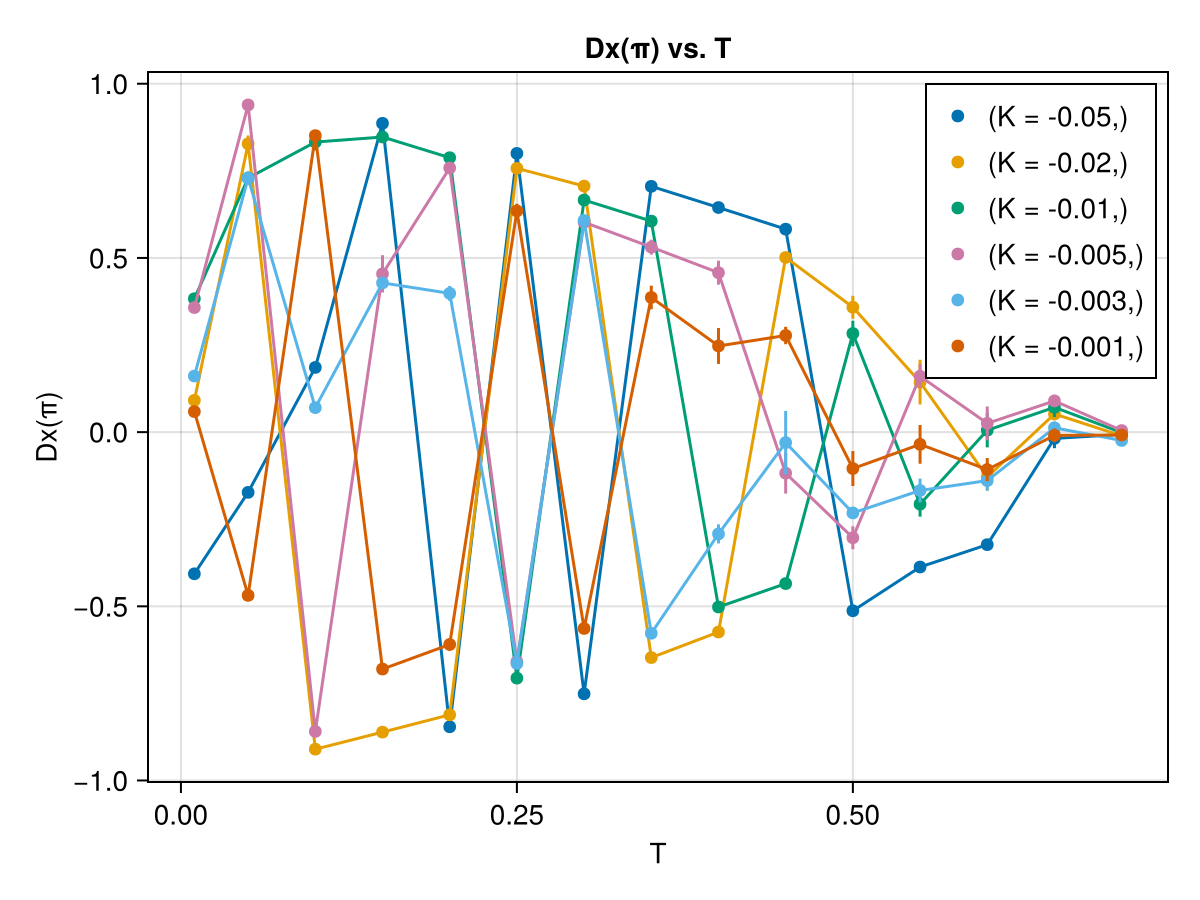

In [43]:
fig = generatePlot(
    neg_K_data, :T, :Dxπ;
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)",
    line=true
)

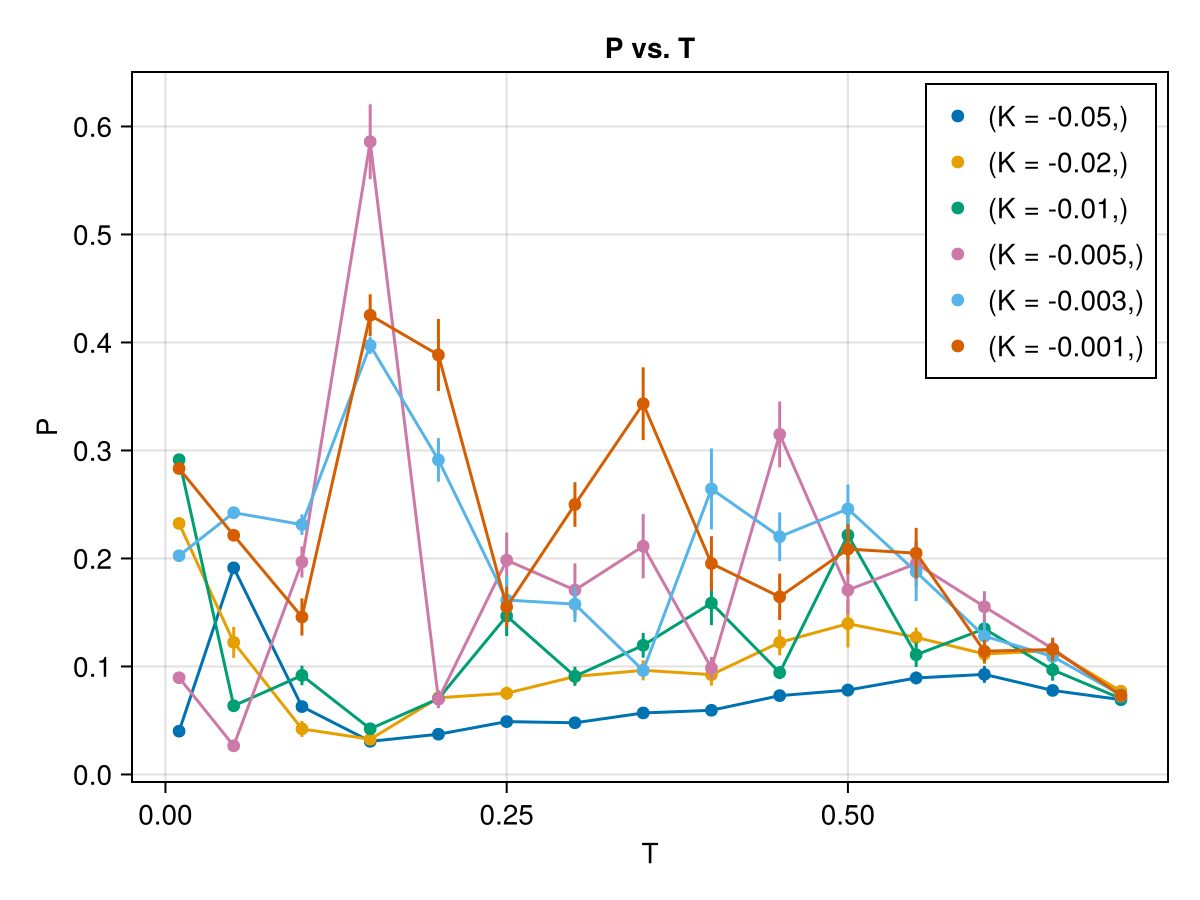

In [44]:
fig = generatePlot(
    neg_K_data, :T, :P;
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)

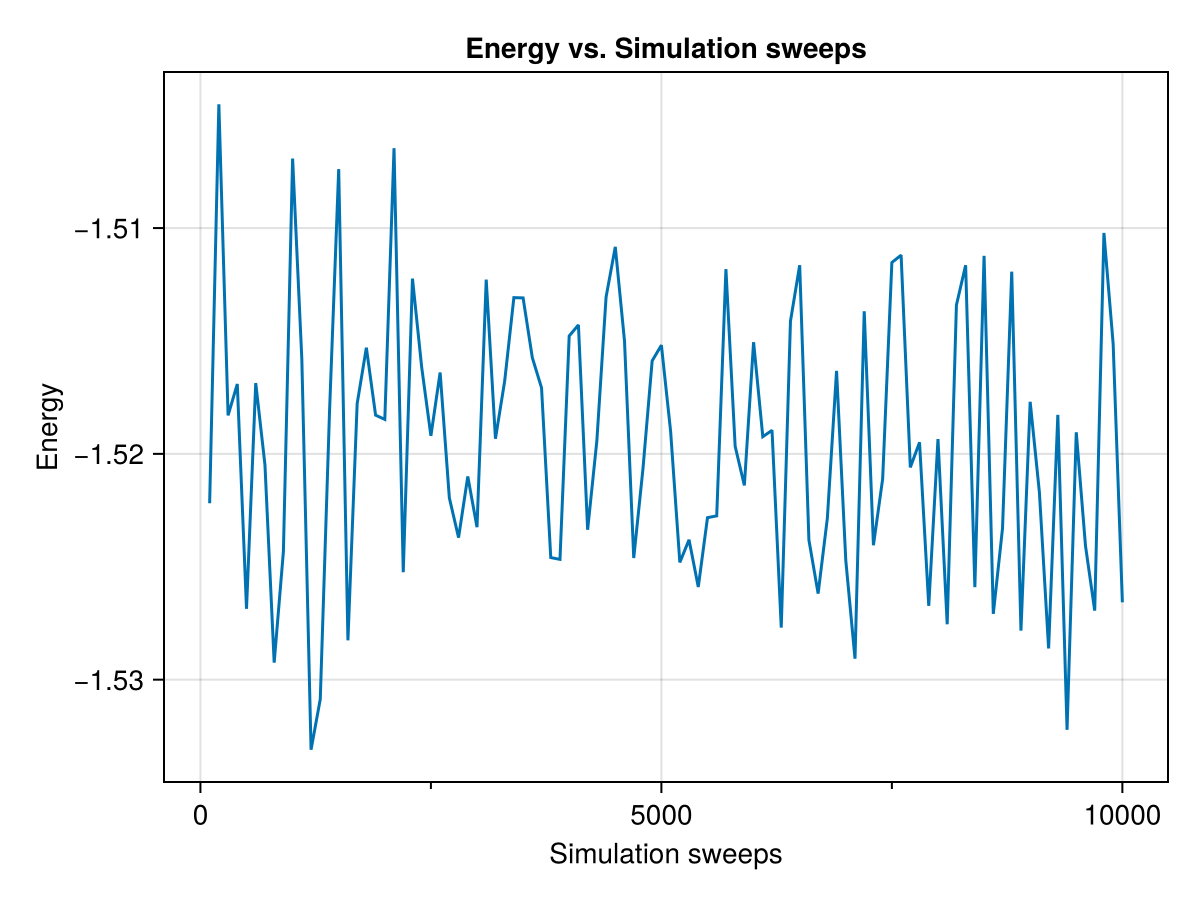

In [37]:
fig = Figure()

ax = fig[1,1] = Axis(
    fig,
    title="Energy vs. Simulation sweeps",
    xlabel="Simulation sweeps",
    ylabel="Energy",
    xminorticksvisible=true
)

task_no = "40"
h5open("../jobs/" * jobname * ".data/task00" * task_no * "/run0001.meas.h5") do file
    mag_group = file["observables/Energy"]
    mag_samples = read(mag_group, "samples")
    bin_len = read(mag_group, "bin_length")
    lines!(
        bin_len .* collect(1:length(mag_samples)),
        mag_samples,
        label="T = 2.2435698905536414"
    )
end

fig

In [38]:
task_no = "42"
file = h5open("../jobs/j1-sweep.data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

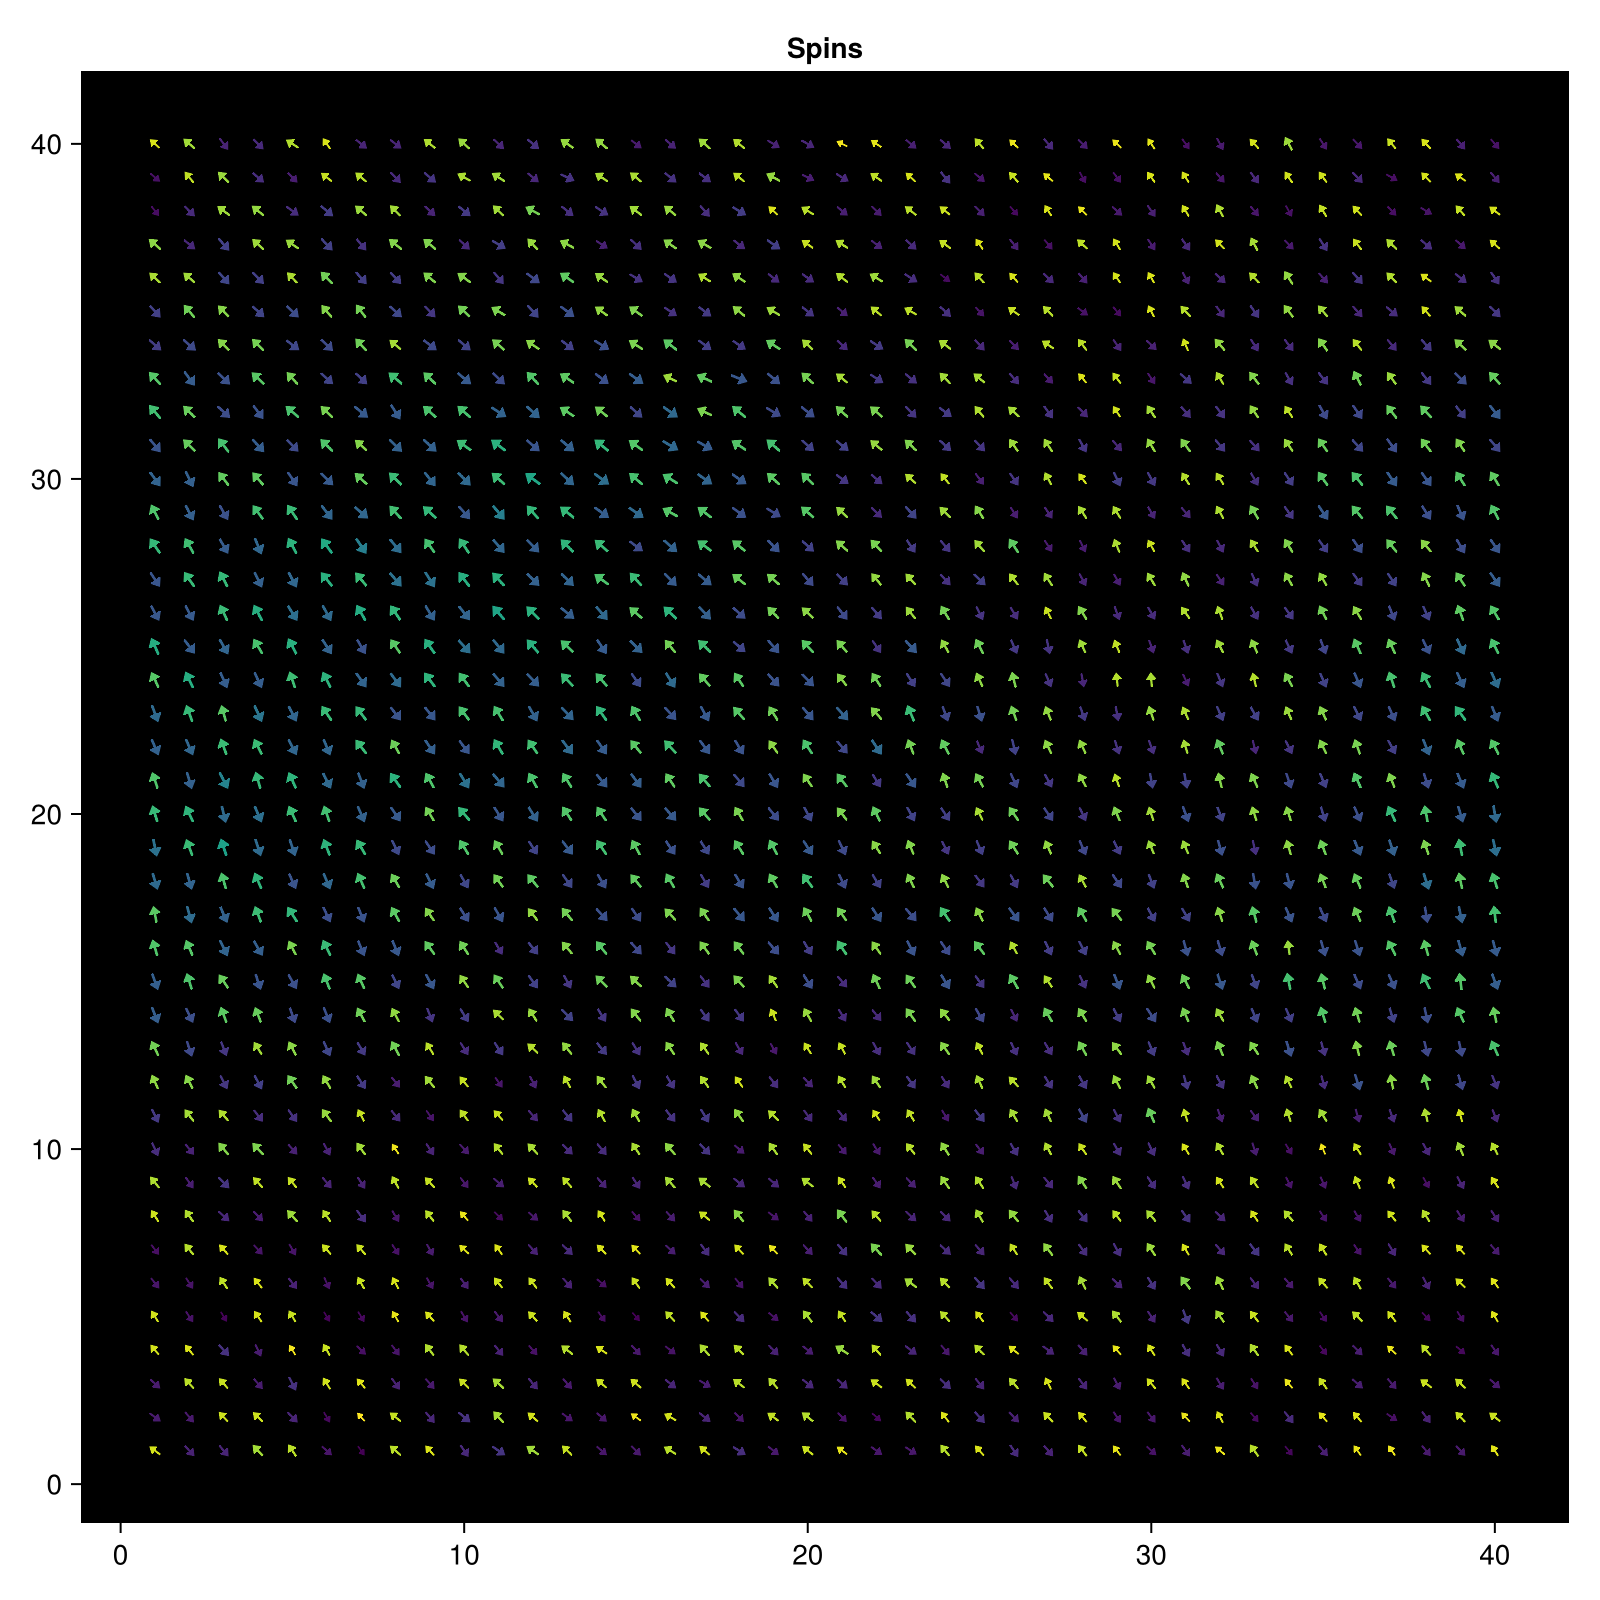

In [39]:
fig = Figure(size=(800, 800))
fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig